<a href="https://colab.research.google.com/github/janchorowski/ml_uwr/blob/fall2019/assignment4/Assignment4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Submission deadline:**
* **Regular problems: last lab session before or on Monday, 13.01.2020**
* **Bonus problems: Last lab during semester**

**Points: 5 + 9 bonus points**

Please note: some of the assignments are tedious or boring if you are already a NumPy ninja. The bonus problems were designed to give you a more satisfying alternative.

## Heads Up!

This assignment comes with starter code, but you are not forced to use it, as long as you execute all analysis demanded in the problems.

## A note about plots!

Plots are a way of communication. Just lke text, they can be paraphrased. You do not have to exactly reproducy my plots, but you must try to make suer yourp plots tell a similar story:
- label axis
- add titles
- choose plot type properly
- choose a color scale, limits, ticks

so that you can describe what is happening!

## Bugs?!

Please submit Github PRs or email us about any problems with the notebook - we will try to correct them quickly. 

In [94]:
# Standard IPython notebook imports
%matplotlib inline

import os

from io import StringIO
import itertools
import httpimport
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook

import scipy.stats as sstats
import scipy.optimize as sopt

import seaborn as sns

import sklearn.datasets
import sklearn.ensemble
import sklearn.svm
import sklearn.tree
import sklearn.utils

import cvxopt


# In this way we can import functions straight from github
with httpimport.github_repo('janchorowski', 'nn_assignments', 
                            module='common', branch='nn18'):
     from common.plotting import plot_mat

sns.set_style('whitegrid')


# SVM Theory
A linear SVM assigns points $x^{(i)}\in\mathbb{R}^n$ to one of two
classes,  $y^{(i)}\in\{-1,1\}$ using the decision rule:

\begin{equation}
y = \text{signum}(w^T x + b).
\end{equation}

SVM training consists of finding weights $w\in\mathbb{R}^n$
and bias $b\in\mathbb{R}$ that maximize the separation margin. This
corresponds to solving the following quadratic optimization problem:

\begin{equation}
\begin{split}
  \min_{w,b,\xi}  &\frac{1}{2}w^Tw  + C\sum_{i=1}^m \xi_i  \\
  \text{s.t. } & y^{(i)}(w^T x^{(i)} + b) \geq 1- \xi_i\;\; \forall_i \\
  & \xi_i \geq 0 \;\; \forall_i.
\end{split}
\end{equation}

# Problem 1 [2p]

Load the iris dataset. 

1. [1p] Using the `sklearn.svm.SVC` library train a linear SVM that
separates the Virginica from the Versicolor class using the
petal length and petal width features. Plot the obtained decision boundary and
the support vectors (their locations and weights - coefficients $\alpha$).

2. [.5p] Now train a nonlinear SVM using the Gaussian kernel. Tune the parameetrs `C` and `gamma` (for the kernel) to reach maximum training accurracy. Plot the decision boundary and supprt vectors.

3. [.5p] Answer the following questions:
    - When the SVM is forced to maximally accurate on the train set, roughly how many support vectors do we get ?
    - what is the relationship between the regularization constant `C` and the support vector weights `alpha`?
  
  

Features:  ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
Targets:  ['setosa' 'versicolor' 'virginica']


Text(0, 0.5, 'petal_width')

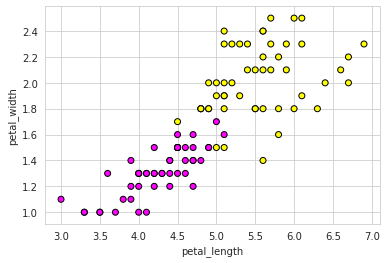

In [44]:
# load iris, extract petal_length and petal_width of versicolors and virginicas

iris = sklearn.datasets.load_iris()
print('Features: ', iris.feature_names)
print('Targets: ', iris.target_names)
petal_length = iris.data[:,iris.feature_names.index('petal length (cm)')]
petal_width = iris.data[:, iris.feature_names.index('petal width (cm)')]

IrisX = np.array(iris.data.T)
IrisX = IrisX[:, iris.target!=0]

IrisX2F = np.vstack([petal_length, petal_width])
IrisX2F = IrisX2F[:, iris.target!=0]
# Set versicolor=0 and virginia=1
IrisY = (iris.target[iris.target!=0]-1).reshape(1,-1).astype(np.float64)

plt.scatter(IrisX2F[0,:], IrisX2F[1,:], c=IrisY.ravel(),
            cmap='spring', edgecolors='k')
plt.xlabel('petal_length')
plt.ylabel('petal_width')

In [28]:
#
# Fit a linear SVM using libsvm
# Use parameter C=10 to be able to compare plots and to have a reference in problem 2
#

svm_model = sklearn.svm.SVC(C=10, kernel='linear')
svm_model.fit(IrisX2F.T, IrisY.T.ravel())

print("libsvm error rate: %f" % ((svm_model.predict(IrisX2F.T)!=IrisY).mean(),))

libsvm error rate: 0.050000


Text(0.5, 1.0, 'Decision boundary found by libsvm')

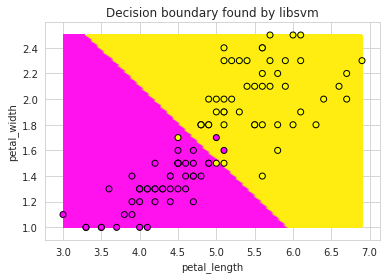

In [31]:
#
# Plot the decision boundary
#

petal_lengths, petal_widths = np.meshgrid(np.linspace(IrisX2F[0,:].min(), IrisX2F[0,:].max(), 100),
                                          np.linspace(IrisX2F[1,:].min(), IrisX2F[1,:].max(), 100))

IrisXGrid = np.vstack([petal_lengths.ravel(), petal_widths.ravel()])
predictions_Grid = svm_model.predict(IrisXGrid.T)

plt.contourf(petal_lengths, petal_widths, predictions_Grid.reshape(petal_lengths.shape), cmap='spring')

plt.scatter(IrisX2F[0,:], IrisX2F[1,:], c=IrisY.ravel(),
            cmap='spring', edgecolors='k')

plt.xlabel('petal_length')
plt.ylabel('petal_width')
plt.title('Decision boundary found by libsvm')

[[-10.         -10.         -10.         -10.         -10.
  -10.          -9.9431904   10.          10.           6.62056728
   10.           7.93677315  10.           5.38584997  10.        ]]


Text(0.5, 1.0, 'Decision boundary found by libsvm')

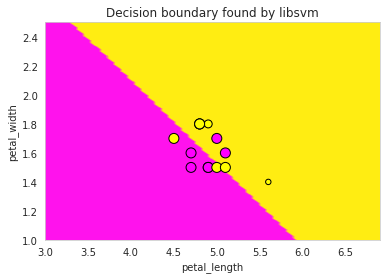

In [43]:
#
# Plot the decision boundary and the support vectors.
#
# You can extract the indices of support vectors and their weights from fielfs of the 
# svm object. Display the loaction of support vectors and their weights (by changing the 
# size in the scatterplot)

support_vector_indices = svm_model.support_
support_vector_coefficients = svm_model.dual_coef_
print(support_vector_coefficients)

plt.contourf(petal_lengths, petal_widths, predictions_Grid.reshape(petal_lengths.shape), cmap='spring')
plt.scatter(*IrisX2F[:, support_vector_indices],
            c=IrisY.ravel()[support_vector_indices],
            s=support_vector_coefficients**2,
            cmap='spring',
            edgecolors='k')

plt.xlabel('petal_length')
plt.ylabel('petal_width')
plt.title('Decision boundary found by libsvm')

libsvm error rate: 0.01
Optimal C = 99
Optimal gamma = 99


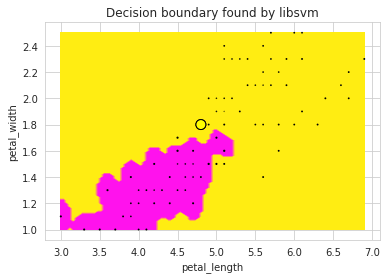

In [93]:
## # Fit a nonlinear SVM with a Gaussian kernel using libsvm.
# Optimize the SVM to make 
#

best_error = 1
optimal_C = -42
optimal_gamma = -42
for gamma in range(1, 100):
    for C in range(1, 100):
        svm_gauss_model = sklearn.svm.SVC(kernel='rbf', C=C, gamma=gamma)
        svm_gauss_model.fit(IrisX2F.T, IrisY.T.ravel())
        if (new_best := (svm_gauss_model.predict(IrisX2F.T)!=IrisY).mean()) <= best_error:
            best_error = new_best
            optimal_C = C
            optimal_gamma = gamma
            #if new_best == 0.01:
            #    print(f'Found optimal values, C = {C}, gamma = {gamma}')
print(f'libsvm error rate: {best_error}')
print(f'Optimal C = {optimal_C}')
print(f'Optimal gamma = {optimal_gamma}')

predictions = svm_gauss_model.predict(IrisXGrid.T)

plt.xlabel('petal_length')
plt.ylabel('petal_width')
plt.title('Decision boundary found by libsvm')

support_vector_indices = svm_gauss_model.support_
support_vector_coefficients = svm_gauss_model.dual_coef_

plt.contourf(petal_lengths, petal_widths, predictions.reshape(petal_lengths.shape), cmap='spring')
plt.scatter(*IrisX2F[:, support_vector_indices],
            c=IrisY.ravel()[support_vector_indices],
            s=abs(support_vector_coefficients),
            cmap='spring',
            edgecolors='k')

# Problem 2 [1p]

Reimplement the linear SVM using the use `cvxopt.solvers.qp`
Quadratic Programming (QP) solver. You will need to define the matrices
that define the problem. Compare the obtained solutions. Extract the
support vectors from the LIBSVM solution and plot the support vectors.

The `cvxopt.solvers.qp` solves the following optimization problem: 

\begin{align}
\text{minimize over } x \text{: }& \frac{1}{2} x^T P x + q^T x \\
\text{subject to: } & Gx \leq h \\
& Ax = b
\end{align}

To solve the SVM problem you need to encode the weights $W$, biases $b$, and slack variables $\xi$ as elements of the vector $x$, then properly fill the matrices and vectors $P$, $q$, $G$, $h$. We can ignore setting the $A$ and $b$ parametrs, since there are no linear constraints.

In [0]:
#
# Now solve the SVM using the QP solver
#

n, m = IrisX2F.shape
C=10.0

P = np.zeros((n+1+m, n+1+m)) #w, bias, xi
q = np.zeros((n+1+m,1)) 
G = np.zeros((2*m, n+1+m)) # we have two constrains for each data point: 
                           # that the margin is equal to 1-xi
                           # and that xi is nonnegative
h = np.zeros((2*m,1))
#
# TODO: fill in P, q, G, h
#

TODO

#
# Now run the solver
#
ret  = cvxopt.solvers.qp(cvxopt.matrix(P), cvxopt.matrix(q), 
                         cvxopt.matrix(G), cvxopt.matrix(h), )

ret = np.array(ret['x'])

#
# extract the weights and biases
#
W = ret[:n].reshape(-1,1)
b = ret[n]

#
# Extract the weight and bias from libsvm for comparison
#
Wlibsvm = TODO
blibsvm = TODO

print('W', W.T, 'Wlibsvm', Wlibsvm)
print('b', b, 'blibsvm', blibsvm)

     pcost       dcost       gap    pres   dres
 0: -8.2045e+03  4.6654e+03  2e+04  2e+01  3e+00
 1:  5.3426e+01 -5.8951e+02  3e+03  2e+00  4e-01
 2:  1.7058e+02 -1.9137e+01  4e+02  3e-01  5e-02
 3:  1.4063e+02  7.5166e+01  1e+02  7e-02  1e-02
 4:  1.3820e+02  9.8722e+01  6e+01  3e-02  5e-03
 5:  1.4016e+02  1.1207e+02  3e+01  4e-03  8e-04
 6:  1.3507e+02  1.1797e+02  2e+01  1e-03  2e-04
 7:  1.2551e+02  1.2356e+02  2e+00  2e-04  3e-05
 8:  1.2445e+02  1.2440e+02  5e-02  4e-06  6e-07
 9:  1.2442e+02  1.2442e+02  1e-03  9e-08  2e-08
10:  1.2442e+02  1.2442e+02  2e-05  1e-09  1e-10
Optimal solution found.
W [[2.75844069 4.827271  ]] Wlibsvm [[2.75873306 4.82861713]]
b [-21.2054472] blibsvm [-21.20914737]


# Problem 3 [2p]

Repeat 100 bootstrap experiments to establish the effect of constant $C$ on SVM.

For each experiment do the following:

1. Sample (with replacement) a bootstrap dataset equal in size to the
    training dataset. This will be this experiment's training dataset.
2. Prepare the experiment's testing dataset by using samples not
    inluded in the bootstrap dataset.
3. For all $C$ from the set $\{10^{-4}, 10^{-3.5}, 10^{-3.}, \ldots, 10^{6}\}$
    fit a nonlinear SVM (Gaussian kernel, called \texttt{rbf} in
    LIBSVM using the default $\gamma$) and record the training and
    testing errors.

Analyze a box plot of errors as a function of $C$. Can you see its
influence on the training and testing error, as well as on the
testing error variability? 

**Indicate regions of overfitting and underfitting.**



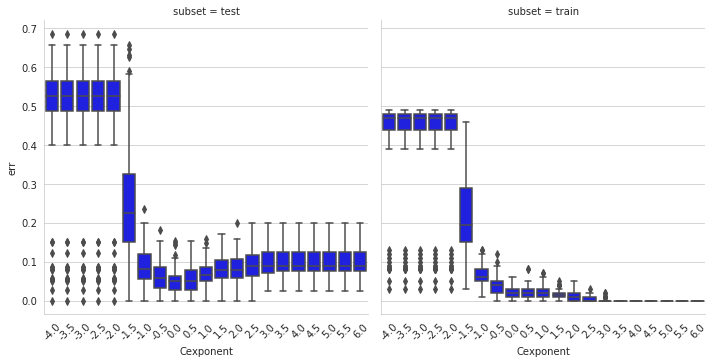

In [125]:
res = []
for rep in range(100):
    bootstrap_sel = sklearn.utils.resample(
        range(IrisX.shape[1]), n_samples=IrisX.shape[1], replace=True)
    test_sel = np.array([i for i in range(IrisX.shape[1]) if i not in bootstrap_sel])

    bootstrap_IrisX = IrisX[:,bootstrap_sel]
    bootstrap_IrisY = IrisY[:,bootstrap_sel]
    
    test_IrisX = IrisX[:,test_sel]
    test_IrisY = IrisY[:,test_sel]
    
    for Cexponent in np.arange(-4, 6.0001, 0.5):
        C = 10.0**Cexponent
        svm_model = sklearn.svm.SVC(kernel='rbf', C=C, gamma='auto')
        svm_model.fit(bootstrap_IrisX.T, bootstrap_IrisY.T.ravel())
        train_acc = (svm_model.predict(bootstrap_IrisX.T) == bootstrap_IrisY.T.ravel()).mean()
        test_acc = (svm_model.predict(test_IrisX.T) == test_IrisY.T.ravel()).mean()
        
        res.append(dict(Cexponent=Cexponent, err=1-test_acc, subset='test'))
        res.append(dict(Cexponent=Cexponent, err=1-train_acc, subset='train'))

res = pd.DataFrame(res)
chart = sns.catplot(kind='box', x='Cexponent', y='err', col='subset', 
            color='blue', data=res)
chart.set_xticklabels(rotation=45)
None

# Problem 4 [3p bonus]

Implement a nonlinear SVM by solving the dual problem using the Quadratic Programming solver. Compare results with LIBSVM.

Please see [page 20 if CS229 lecture notes](http://cs229.stanford.edu/notes/cs229-notes3.pdf) for problem formulation.

# Problem 5 [2p bonus]
Compare two ways to implement a multi-class
SVM: by training ``1-vs-1'' classifier for each class combination,
and by training a ``1-vs-rest'' classifier for each clas. See
http://www.csie.ntu.edu.tw/\~cjlin/papers/multisvm.pdf for
details.


# Problem 6 [4p bonus]

Implement a Kernelized linear regression. Train it on Iris using a Gaussian kernel. Compare to the non-linear SVM.